In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
traindata = pd.read_csv("/content/drive/MyDrive/Humana/2021_Competition_Training.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,8,9,11,13,16,20,26,28,29,31,33,51,55,58,62,64,66,68,75,85,102,124,127,131,132,135,160,174,180,187,192,202,209,210,211,215,220,230,234,240,243,247,251,255,261,285,293,297,300,305,306,309,323,334,344,345,352,353,355,359) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
testdata = pd.read_csv("/content/drive/MyDrive/Humana/2021_Competition_Holdout.csv")

# 1. Data Preprocessing
  
* Detect and identify missing values
* Correct data types
* Remove useless features
* Adding information
* Handle missing values
* Standardize data

In [ ]:
# According to Warinings, print value summaries of all the features that have mixed types
train_mixtypelist = [2,8,9,11,13,16,20,26,28,29,31,33,51,55,58,62,64,66,68,
                     75,85,102,124,127,131,132,135,160,174,180,187,192,202,
                     209,210,211,215,220,230,234,240,243,247,251,255,261,285,
                     293,297,300,305,306,309,323,334,344,345,352,353,355,359]
test_mixtypelist = [2,8,9,11,13,16,20,26,28,29,31,33,51,55,58,62,64,66,75,
                    82,85,102,124,131,132,135,159,173,179,191,208,209,210,
                    219,233,239,246,254,260,284,287,292,296,304,305,307,308,
                    322,333,343,344,349,351,352,354]

In [ ]:
def Datacleaning(data, indexlist):
  df = data.copy()
  indexlst = indexlist.copy()
  print("Start data cleaning...")
  # 1. Replace "*" with na value
  df.replace(["*", " "], np.nan, inplace=True)
  print("Step 1 completed!")
  # 2. In indexlist, all features are numeric except src_div_id,
  # so we should implement it in a different way
  df.loc[:, "src_div_id"] = df.loc[:, "src_div_id"].astype("object")
  print("Step 2 completed!")
  # 3. Remove sri_div_id index from indexlist
  indexlst.remove(df.columns.to_list().index("src_div_id"))
  print("Step 3 completed!")
  # 4. Change all features to appropriate dtypes
  df.iloc[:, indexlst] = df.iloc[:, indexlst].astype("float64")
  col_rest = ["cms_orig_reas_entitle_cd","race_cd","atlas_type_2015_update","cms_orig_reas_entitle_cd"]
  df.loc[:, col_rest] = df.loc[:, col_rest].astype("object")
  df['hedis_dia_hba1c_ge9'].replace({"Y":1,"N":0},inplace = True)
  print("Step 4 completed!")
  # 5. Sort columns alphabetically
  df = df.reindex(sorted(df.columns), axis=1)
  print("Step 5 completed!")
  # 6. Drop Unnamed:0, zip_cd, features that contain only one value or few diversity
  col_useless = ["Unnamed: 0","zip_cd"]
  for i in df:
    valuesum = df[i].value_counts()
    perc = valuesum.max()/valuesum.sum()
    if valuesum.size == 1:
      col_useless.append(i)
    elif (valuesum.size == 2) & (perc>0.999):
      col_useless.append(i)
  df.drop(columns=col_useless, inplace=True)  
  print("Data cleaning completed!")
  return df


In [ ]:
def FeatureProcessing(data):
  print("Start feature processing...")
  df = data.copy()
  #1. Create new features for rows with similar NA patterns
  cons_feature = [
      'cons_chmi', 'cons_lwcm10', 'cons_cwht', 'cons_n2pmr', 'cons_cgqs',
      'cons_rxadhm', 'cons_estinv30_rc', 'cons_nwperadult',
      'cons_n2phi', 'cons_chva', 'cons_lwcm07', 'cons_hxwearbl',
      'cons_stlnindx', 'cons_rxadhs', 'cons_n2pwh', 'cons_rxmaint',
      'cons_hxmioc'
  ]
  atlas_feature = [
      'atlas_pct_fmrkt_baked16', 'atlas_pct_fmrkt_anmlprod16',
      'atlas_pct_fmrkt_sfmnp16', 'atlas_pct_fmrkt_wiccash16',
      'atlas_pct_fmrkt_wic16', 'atlas_pct_fmrkt_snap16',
      'atlas_pct_fmrkt_otherfood16', 'atlas_pct_fmrkt_credit16',
      'atlas_pct_fmrkt_frveg16'
  ]
  df["cons_17na"] = ((df.loc[:,cons_feature].shape[1] \
            - df.loc[:,cons_feature].count(axis=1))==17).astype("Int64")

  df["atlas_9na"] = ((df.loc[:,atlas_feature].shape[1] \
            - df.loc[:,atlas_feature].count(axis=1))==9).astype("Int64")

  df["mabh_seg_na"] = df.loc[:, "mabh_seg"].isnull().astype("Int64")
  # 2. Fairness adjustment
  adjlist = ["race_cd","sex_cd","cons_hhcomp","rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4"]
  df.drop(columns=adjlist, inplace=True)
  # df = df.convert_dtypes(convert_string=False)
  print("Feature processing completed!")
  return df

In [ ]:
def Getobjlist(data,istest=False):
  objlist = data.select_dtypes(include="object").columns.to_list()
  objlist.remove("ID")
  if not istest:
    objlist.remove("covid_vaccination")
  return objlist

In [ ]:
def Fillna(data):
  print("Start filling na...")
  df = data.copy()
  objlist = df.select_dtypes(include="object").columns.to_list()
  # Handling missing values for categorical features:
  for column in objlist:
    bef_fill = df.loc[:, column]
    if bef_fill.isna().sum()/df.shape[0] > 0.1:
      df.loc[:, column] = df.loc[:, column].fillna("Blank")
    else:
      df.loc[:,column] = df.loc[:, column].fillna(bef_fill.mode()[0])
  print("Filling na completed!")
  return df

In [ ]:
def Standardize(data,objlist,istest=False):
  print("Start Standardizing...")
  df = data.copy()
  # 1. devide X and y for traindata
  if not istest:
    data_X = df.drop(columns = ["covid_vaccination"])
    label = df["covid_vaccination"] 
    label.replace({"no_vacc": 0, "vacc": 1},inplace = True)# concat later
  else:
    data_X = df.copy()
  del df
  print("Step 1 completed!")
  # 2. Turn categorical features into ordinal type
  objcol = objlist
  ord_enc = OrdinalEncoder()
  data_str = data_X.loc[:,objcol].astype("str")
  data_ord = ord_enc.fit_transform(data_str)
  del data_str
  data_ord = pd.DataFrame(data_ord, columns=objcol)
  data_ord = data_ord.astype("category") # concat later
  print("Step 2 completed!")
  # 3. Standardize all numerical features
  scaler = StandardScaler()
  objcol.append("ID")
  data_int = data_X.drop(columns = objcol)
  del data_X
  data_int_s = scaler.fit_transform(data_int.astype(float))
  data_int_s = pd.DataFrame(data_int_s, columns=data_int.columns,dtype="float32")# concat later
  del data_int
  if not istest:
    df = pd.concat([data_int_s,data_ord,label],axis=1)
  else:
    df = pd.concat([data_int_s,data_ord],axis=1)
  print("Standardizing completed!")
  return df

In [ ]:
def SplitXy(data):
  df = data.copy()
  y = df.loc[:,"covid_vaccination"]
  X = df.drop(columns = ["covid_vaccination"])
  return X, y

In [ ]:
traindata_clean = Datacleaning(traindata, train_mixtypelist)

Start data cleaning...
Step 1 completed!
Step 2 completed!
Step 3 completed!
Step 4 completed!
Step 5 completed!
Data cleaning completed!


In [ ]:
traindata_featureprocess = FeatureProcessing(traindata_clean)

Start feature processing...
Feature processing completed!


In [ ]:
objlist = Getobjlist(traindata_featureprocess)

In [ ]:
traindata_fillna = Fillna(traindata_featureprocess)

Start filling na...
Filling na completed!


In [ ]:
traindata_standard = Standardize(traindata_fillna,objlist)

Start Standardizing...
Step 1 completed!
Step 2 completed!
Standardizing completed!


In [ ]:
X,y = SplitXy(traindata_standard)

In [ ]:
del traindata_clean
del traindata_featureprocess
del traindata
del traindata_fillna
del traindata_standard

# 2. Build LightGBM Classification Model
  
* Split train and test set
* Build prediction model
* Get feature importance
* Parameters tuning using cross validation


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Split train and test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1204)

## Build classification model

In [ ]:
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
              objective="binary", 
              metric = 'auc',
              random_state = 1204,
              max_depth = 12,
              num_leaves = 42,
              learning_rate = 0.05,
              n_estimators = 500)
gbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=12,
               metric='auc', min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=42,
               objective='binary', random_state=1204, reg_alpha=0.0,
               reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred = gbm.predict_proba(X_test)
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(y_test, y_pred[:,1])
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)
roc_auc_lr

0.6836656500531908

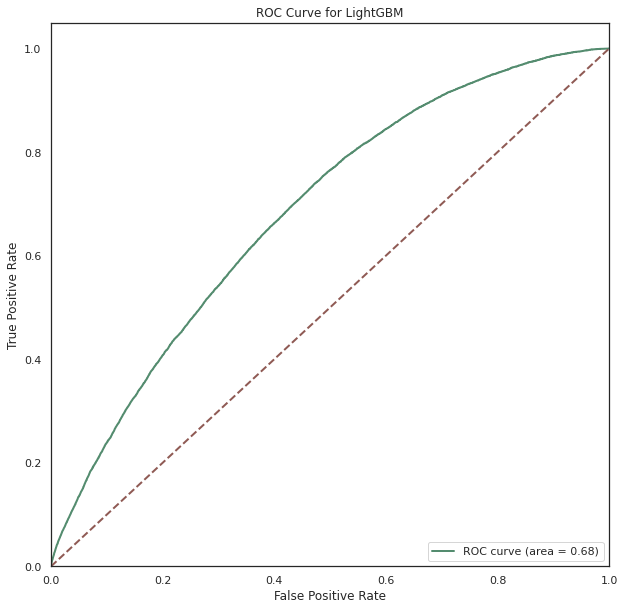

In [ ]:
plt.figure(figsize=(10,10))
sns.set_style("white")
lw = 2
plt.plot(fpr_lr, tpr_lr, color='#548C6F',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='#8F5A54', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LightGBM')
plt.legend(loc="lower right")
plt.show()

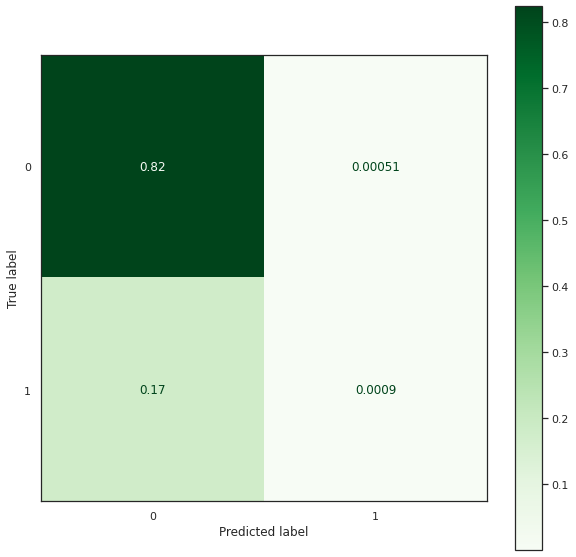

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set_theme(style="white")
metrics.plot_confusion_matrix(gbm,X_test,y_test,cmap=plt.cm.Greens,normalize="all",ax = ax)
plt.show()

## Get feature importance

In [ ]:
model = lgb.LGBMClassifier(boosting_type = 'gbdt',
              objective="binary", 
              metric = 'auc',
              random_state = 1204,
              max_depth = 12,
              num_leaves = 42,
              learning_rate = 0.05,
              n_estimators = 500).fit(X_train, y_train)

In [ ]:
model.importance_type = "gain"

In [ ]:
import seaborn as sns
def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_ ,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 4)
    sns.set_style("whitegrid")
    sns.barplot(x="Value", y="Feature", 
          data=feature_imp.sort_values(by="Value",ascending=False)[0:num],
          palette = sns.light_palette("#548C6F",reverse=True,n_colors=60))    
    plt.title('LightGBM Features Importance (Top 50)')
    plt.tight_layout()
    plt.xlabel("Total gains of splits")
    plt.savefig('lgbm_importances-01.png')
    plt.show()

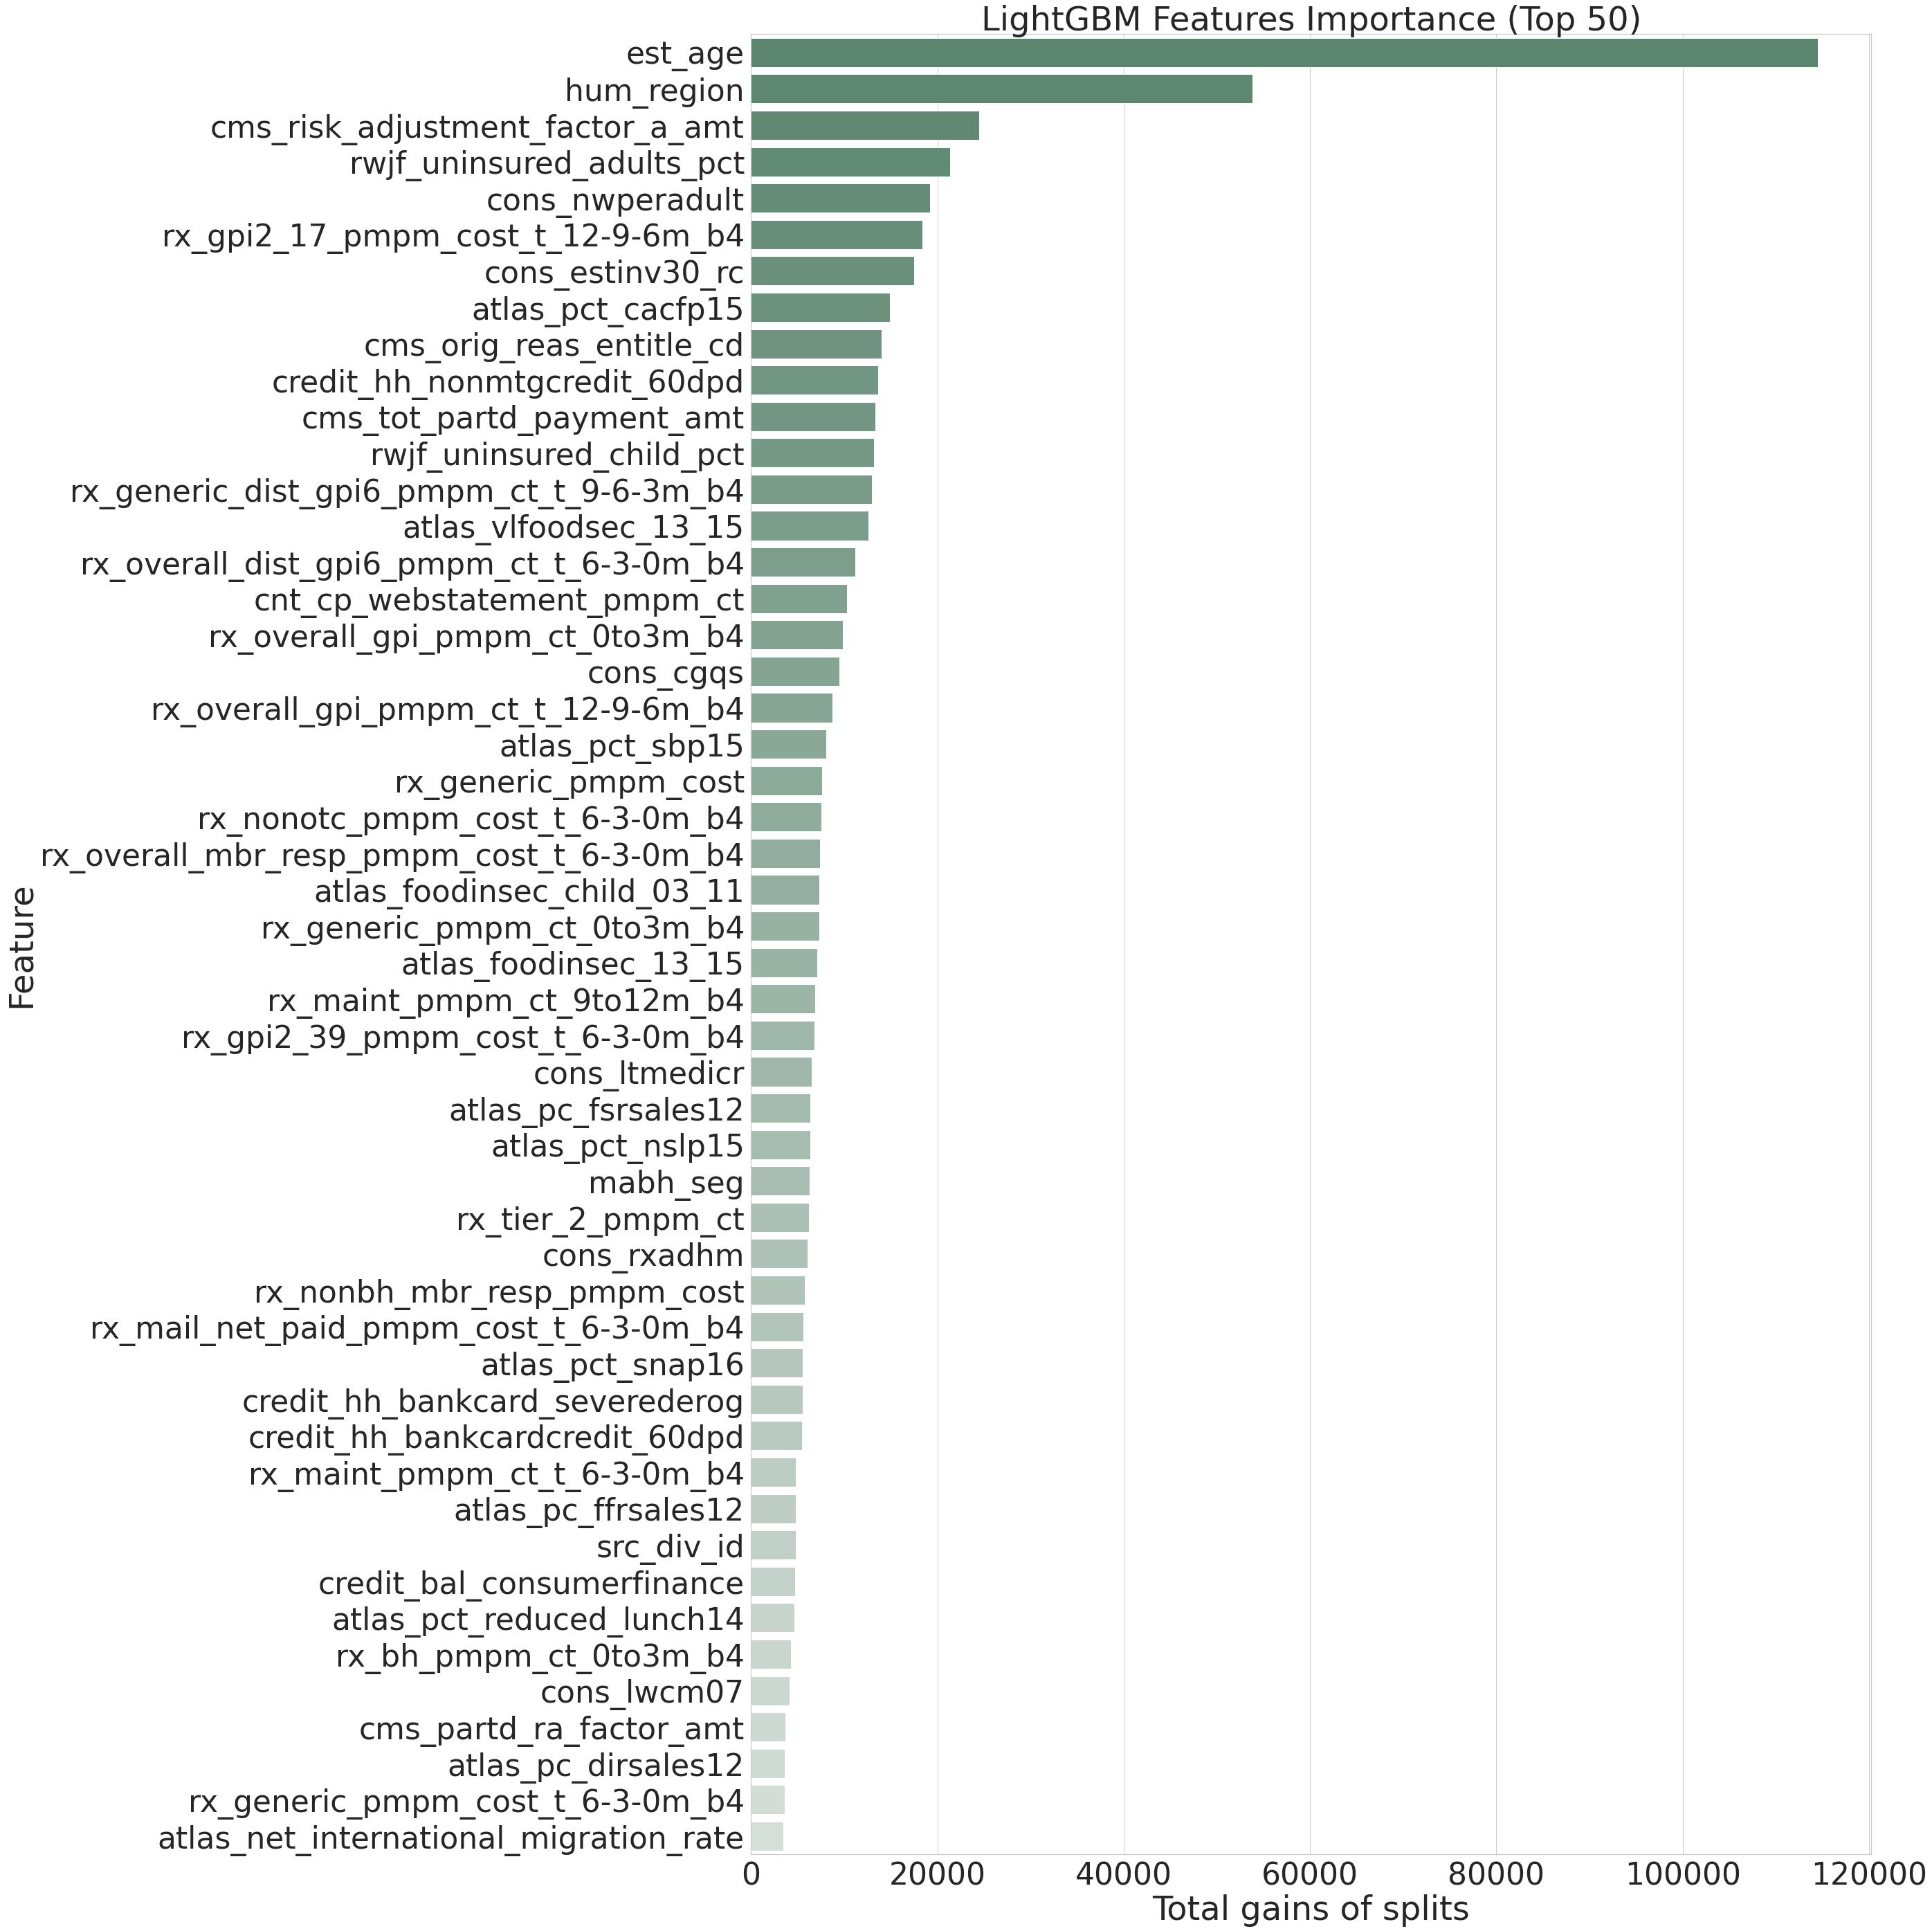

In [ ]:
plotImp(model, X_train , num = 50, fig_size = (40, 40))

In [ ]:
Feature_Imp = pd.DataFrame({"Feature":X.columns.to_list(),
               "Importance":model.feature_importances_.tolist()}).sort_values(by = "Importance",ascending = False).reset_index(drop = True)


In [ ]:
Feature_Imp.head(40).to_csv("40 most important features.csv")

In [ ]:
impf = Feature_Imp.head(40).Feature.to_list()
impf.append("covid_vaccination")
df_imp = traindata_clean.loc[:,impf]
df_imp

In [ ]:
df_imp.to_csv("/content/drive/MyDrive/Humana/EDAfile.csv",index=False)

## Parameters tuning

In [ ]:
parameters = {
    "bagging_freq":[10,20,50,100],
    "bagging_fraction":[0.1,0.2,0.5,1]
}#自定义需要调的参数以及区间
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
              objective="binary", 
              metric = 'auc',
              random_state = 1204,
              max_depth = 12,
              num_leaves = 42,
              learning_rate = 0.05,
              n_estimators = 500
              ) 

gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=5)
gsearch.fit(X, y)

print("Best score: %0.8f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))# 0.68192742

Best score: 0.68192742
Best parameters set:
	bagging_fraction: 1
	bagging_freq: 10


In [ ]:
# Use best parameters to refine prediction model:
gbm = lgb.LGBMClassifier(boosting_type = 'gbdt',
              metric = 'auc',
              objective="binary", 
              random_state = 1204)
gbm.fit(X_train, y_train,categorical_feature = objlist)

# 3. Predict Test Dataset

In [ ]:
testdata_clean = Datacleaning(testdata, test_mixtypelist)

Start data cleaning...
Step 1 completed!
Step 2 completed!
Step 3 completed!
Step 4 completed!
Step 5 completed!
Data cleaning completed!


In [ ]:
test_featureprocess = FeatureProcessing(testdata_clean)

Start feature processing...
Feature processing completed!


In [ ]:
testdata_fillna = Fillna(test_featureprocess)

Start filling na...
Filling na completed!


In [ ]:
ID = testdata_fillna["ID"]

In [ ]:
testdata_standard = Standardize(testdata_fillna,True)

Start Standardizing...
Step 1 completed!
Step 2 completed!
Standardizing completed!


In [ ]:
y_holdout = gbm.predict_proba(testdata_standard)

In [ ]:
df_predict = pd.DataFrame({"ID":ID, "Score": y_holdout[:,0]})
df_predict["Score"] = df_predict["Score"].astype("float32")
df_predict.sort_values(by="Score",ascending = False,inplace = True)
df_predict.reset_index(drop=True,inplace=True)
df_predict["Rank"] = df_predict.index+1
df_predict["Rank"] = df_predict["Rank"].astype("int32")
df_predict

In [ ]:
df_predict.to_csv("/content/drive/MyDrive/Humana/2021CaseCompetition_Yichao_Liu_20211005.csv",index=False)

---
# Some extra exploration

1. Figure out different kinds of NA (blank value, "*") (**Solved**)
2. Comparing correlation of different features to race and sex


In [ ]:
# 1. Indentify whether * and NAN should be treated separately.
for i in traindata:
  if (sum(traindata[i]=="*")>0) & (traindata[i].isna().sum()>0):
    print(i)
    print("Number of *: ",sum(traindata[i]=="*"))
    print("Number of NA: ",traindata[i].isna().sum())
# Conclision: No need to treat separately.

In [ ]:
# 2. Comparing correlation of different features to race and sex
sex = traindata_clean["sex_cd"]
race = traindata_clean["race_cd"]
df = traindata_clean.drop(columns=["sex_cd","race_cd","covid_vaccination"])  

In [ ]:
df_corr = pd.DataFrame(columns=["Feature","Dtype","Sex_Chi2pvalue","Sex_CramersV","Race_Chi2pvalue","Race_CramersV"])
cnt=0
for i in df:
  dtype = df[i].dtype
  if (df[i].unique().size<=5) | (df[i].dtype=="object"):
    # Sex
    ct1 = np.array(pd.crosstab(sex,df[i]))
    stat1, p1, dof1, expected1 = stats.chi2_contingency(ct1)
    p1 = round(p1,4)
    n1 = ct1.sum()
    minDim1 = min(ct1.shape)-1
    V_sex = np.sqrt((stat1/n1) /minDim1)
    # Race
    ct2 = np.array(pd.crosstab(race,df[i]))
    stat2, p2, dof2, expected2 = stats.chi2_contingency(ct2)
    p2 = round(p2,4)
    n2 = ct2.sum()
    minDim2 = min(ct2.shape)-1
    V_race = np.sqrt((stat2/n2) /minDim2)
    df_corr.loc[cnt]=[i,dtype,p1,V_sex,p2,V_race]
  else:
    col_cat = pd.cut(df[i],bins=5)
    # Sex
    ct1 = np.array(pd.crosstab(sex,col_cat))
    stat1, p1, dof1, expected1 = stats.chi2_contingency(ct1)
    p1 = round(p1,4)
    n1 = ct1.sum()
    minDim1 = min(ct1.shape)-1
    V_sex = np.sqrt((stat1/n1) /minDim1)
    # Race
    ct2 = np.array(pd.crosstab(race,col_cat))
    stat2, p2, dof2, expected2 = stats.chi2_contingency(ct2)
    p2 = round(p2,4)
    n2 = ct2.sum()
    minDim2 = min(ct2.shape)-1
    V_race = np.sqrt((stat2/n2) /minDim2)
    df_corr.loc[cnt]=[i,dtype,p1,V_sex,p2,V_race]
  cnt+=1

In [ ]:
df_corr.sort_values(by="Sex_CramersV",ascending=False).head(5)

,Feature,Dtype,Sex_Chi2pvalue,Sex_CramersV,Race_Chi2pvalue,Race_CramersV
155,cons_hhcomp,object,0.0,0.523256,0.0,0.054629
248,rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4,float64,0.0,0.298459,0.0,0.010242
159,cons_lwcm07,float64,0.0,0.211874,0.0,0.068932
168,cons_rxmaint,Int64,0.0,0.176616,0.0,0.065888
158,cons_ltmedicr,Int64,0.0,0.103858,0.0,0.064870


In [ ]:
df_corr.sort_values(by="Race_CramersV",ascending=False).head(5)

,Feature,Dtype,Sex_Chi2pvalue,Sex_CramersV,Race_Chi2pvalue,Race_CramersV
164,cons_n2pwh,Int64,0.000,0.034991,0.0,0.198830
191,lang_spoken_cd,object,0.001,0.009464,0.0,0.188616
184,credit_num_nonmtgcredit_60dpd,float64,0.000,0.025924,0.0,0.153675
179,credit_hh_nonmtgcredit_60dpd,float64,0.000,0.020660,0.0,0.151157
156,cons_hxmioc,Int64,0.000,0.036836,0.0,0.138783
